## Downloading dataset and predefined train, test and validation splits

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                             title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                  9KB  2022-10-06 08:55:25          11726        367  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset           11KB  2022-09-30 04:05:11           9347        288  1.0              
stetsondone/video-game-sales-by-genre                           Video Game Sales by Genre                        12KB  2022-10-31 17:56:01            937         23  1.0              
whenamancodes/credit-card-customers-prediction

In [2]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:29<00:00, 38.9MB/s]
100% 1.04G/1.04G [00:29<00:00, 37.5MB/s]


In [3]:
!wget http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip

--2022-11-11 18:07:07--  http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip [following]
--2022-11-11 18:07:07--  https://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36745453 (35M) [application/zip]
Saving to: ‘caption_datasets.zip’

caption_datasets.zi 100%[===================>]  35.04M  12.7MB/s    in 2.8s    

2022-11-11 18:07:10 (12.7 MB/s) - ‘caption_datasets.zip’ saved [36745453/36745453]



In [4]:
!unzip -q ./caption_datasets.zip

In [5]:
!unzip -q flickr8k.zip

## Helper Functions

In [6]:
import os
import numpy as np
import h5py
import json
import torch
from imageio import imread
from skimage.transform import resize
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample

In [7]:
def create_input_files(dataset, karpathy_json_path, image_folder, captions_per_image, min_word_freq, output_folder,max_len=100):
  assert dataset in {'coco', 'flickr8k', 'flickr30k'}

  with open(karpathy_json_path, 'r') as j:
      data = json.load(j)
  
  train_image_paths = []
  train_image_captions = []
  val_image_paths = []
  val_image_captions = []
  test_image_paths = []
  test_image_captions = []
  word_freq = Counter()

  for img in data['images']:
    captions = []
    for c in img['sentences']:
        word_freq.update(c['tokens'])
        if len(c['tokens']) <= max_len:
            captions.append(c['tokens'])

    if len(captions) == 0:
        continue
    
    path = os.path.join(image_folder, img['filepath'], img['filename']) if dataset == 'coco' else os.path.join(
            image_folder, img['filename'])

    if img['split'] in {'train', 'restval'}:
        train_image_paths.append(path)
        train_image_captions.append(captions)
    elif img['split'] in {'val'}:
        val_image_paths.append(path)
        val_image_captions.append(captions)
    elif img['split'] in {'test'}:
        test_image_paths.append(path)
        test_image_captions.append(captions)

  assert len(train_image_paths) == len(train_image_captions)
  assert len(val_image_paths) == len(val_image_captions)
  assert len(test_image_paths) == len(test_image_captions)

  words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
  word_map = {k: v + 1 for v, k in enumerate(words)}
  word_map['<unk>'] = len(word_map) + 1
  word_map['<start>'] = len(word_map) + 1
  word_map['<end>'] = len(word_map) + 1
  word_map['<pad>'] = 0
  
  base_filename = dataset + '_' + str(captions_per_image) + '_cap_per_img_' + str(min_word_freq) + '_min_word_freq'

  with open(os.path.join(output_folder, 'WORDMAP_' + base_filename + '.json'), 'w') as j:
      json.dump(word_map, j)

  seed(123)
  for impaths, imcaps, split in [(train_image_paths, train_image_captions, 'TRAIN'),
                                  (val_image_paths, val_image_captions, 'VAL'),
                                  (test_image_paths, test_image_captions, 'TEST')]:

      with h5py.File(os.path.join(output_folder, split + '_IMAGES_' + base_filename + '.hdf5'), 'a') as h:
          
          h.attrs['captions_per_image'] = captions_per_image

          
          images = h.create_dataset('images', (len(impaths), 3, 256, 256), dtype='uint8')

          print("\nReading %s images and captions, storing to file...\n" % split)

          enc_captions = []
          caplens = []

          for i, path in enumerate(tqdm(impaths)):

              
              if len(imcaps[i]) < captions_per_image:
                  captions = imcaps[i] + [choice(imcaps[i]) for _ in range(captions_per_image - len(imcaps[i]))]
              else:
                  captions = sample(imcaps[i], k=captions_per_image)

              
              assert len(captions) == captions_per_image

              
              img = imread(impaths[i])
              if len(img.shape) == 2:
                  img = img[:, :, np.newaxis]
                  img = np.concatenate([img, img, img], axis=2)
              img = resize(img, (256, 256))
              img = img.transpose(2, 0, 1)
              assert img.shape == (3, 256, 256)
              assert np.max(img) <= 255

              
              images[i] = img

              for j, c in enumerate(captions):
                  
                  enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in c] + [
                      word_map['<end>']] + [word_map['<pad>']] * (max_len - len(c))

                  
                  c_len = len(c) + 2

                  enc_captions.append(enc_c)
                  caplens.append(c_len)

          assert images.shape[0] * captions_per_image == len(enc_captions) == len(caplens)

          with open(os.path.join(output_folder, split + '_CAPTIONS_' + base_filename + '.json'), 'w') as j:
              json.dump(enc_captions, j)

          with open(os.path.join(output_folder, split + '_CAPLENS_' + base_filename + '.json'), 'w') as j:
              json.dump(caplens, j)

In [8]:
def init_embedding(embeddings):
    bias = np.sqrt(3.0 / embeddings.size(1))
    torch.nn.init.uniform_(embeddings, -bias, bias)

In [9]:
def load_embeddings(emb_file, word_map):
    with open(emb_file, 'r') as f:
        emb_dim = len(f.readline().split(' ')) - 1

    vocab = set(word_map.keys())
    embeddings = torch.FloatTensor(len(vocab), emb_dim)
    init_embedding(embeddings)
    print("\nLoading embeddings...")
    for line in open(emb_file, 'r'):
        line = line.split(' ')

        emb_word = line[0]
        embedding = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))
        if emb_word not in vocab:
            continue

        embeddings[word_map[emb_word]] = torch.FloatTensor(embedding)

    return embeddings, emb_dim

In [10]:
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [11]:
def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)
    if is_best:
        torch.save(state, 'BEST_' + filename)

In [12]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
def adjust_learning_rate(optimizer, shrink_factor):
    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

In [14]:
def accuracy(scores, targets, k):
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()
    return correct_total.item() * (100.0 / batch_size)

## Creating input files

In [15]:
create_input_files(
    dataset = 'flickr8k',
    karpathy_json_path = './dataset_flickr8k.json',
    image_folder = './Images/',
    captions_per_image = 5,
    min_word_freq = 5,
    output_folder = './Images/',
    max_len = 50
)


Reading TRAIN images and captions, storing to file...



100%|██████████| 6000/6000 [02:55<00:00, 34.15it/s]



Reading VAL images and captions, storing to file...



100%|██████████| 1000/1000 [00:28<00:00, 34.66it/s]



Reading TEST images and captions, storing to file...



100%|██████████| 1000/1000 [00:28<00:00, 34.66it/s]


## Creating Dataset for PyTorch using the Dataset class in PyTorch so that the dataset can be used for training, eval and testing

In [16]:
import torch
from torch.utils.data import Dataset
import h5py
import json
import os

In [17]:
class CaptionDataset(Dataset):
  def __init__(self,data_folder,data_name,split,transform = None):
    self.split = split
    assert self.split in {"TRAIN","VAL","TEST"}

    self.h = h5py.File(os.path.join(data_folder, self.split + '_IMAGES_' + data_name + '.hdf5'), 'r')
    self.imgs = self.h['images']
    self.cpi = self.h.attrs['captions_per_image']
    with open(os.path.join(data_folder, self.split + '_CAPTIONS_' + data_name + '.json'), 'r') as j:
        self.captions = json.load(j)
    with open(os.path.join(data_folder, self.split + '_CAPLENS_' + data_name + '.json'), 'r') as j:
        self.caplens = json.load(j)
    self.transform = transform

    self.dataset_size = len(self.captions)
  
  def __getitem__(self, i):
    img = torch.FloatTensor(self.imgs[i // self.cpi] / 255.)
    if self.transform is not None:
        img = self.transform(img)

    caption = torch.LongTensor(self.captions[i])

    caplen = torch.LongTensor([self.caplens[i]])

    if self.split is 'TRAIN':
        return img, caption, caplen
    else:
        all_captions = torch.LongTensor(
            self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
        return img, caption, caplen, all_captions

  def __len__(self):
      return self.dataset_size

## Creating the Encoder and Decoder Architecture for model training

In [18]:
import torch
from torch import nn
import torchvision

In [19]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "cpu"
)

In [20]:
device

device(type='cuda')

In [21]:
class Encoder(nn.Module):
  def __init__(self,encoded_image_size = 14):
    super(Encoder,self).__init__()
    self.enc_image_size = encoded_image_size
    resnet = torchvision.models.resnet101(pretrained = True)
    modules = list(resnet.children())[:-2]
    self.resnet = nn.Sequential(*modules)
    self.addaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size,encoded_image_size))
    self.fine_tune()
  
  def forward(self,images):
    out = self.resnet(images)
    out = self.addaptive_pool(out)
    out = out.permute(0,2,3,1)
    return out
  
  def fine_tune(self,fine_tune = True):
    for p in self.resnet.parameters():
      p.requires_grad = False
    for c in list(self.resnet.children())[5:]:
      for p in c.parameters():
        p.required_grad = fine_tune

In [22]:
class Attention(nn.Module):
  def __init__(self,encoder_dim,decoder_dim,attention_dim):
    super(Attention,self).__init__()
    self.encoder_att = nn.Linear(encoder_dim,attention_dim)
    self.decoder_att = nn.Linear(decoder_dim,attention_dim)
    self.full_att = nn.Linear(attention_dim,1)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim = 1)
  
  def forward(self,encoder_out,decoder_hidden):
    att1 = self.encoder_att(encoder_out)
    att2 = self.decoder_att(decoder_hidden)
    att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
    alpha = self.softmax(att)
    attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim = 1)
    return attention_weighted_encoding, alpha

In [23]:
class DecoderWithAttention(nn.Module):

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        embeddings = self.embedding(encoded_captions) 
        h, c = self.init_hidden_state(encoder_out)
        decode_lengths = (caption_lengths - 1).tolist()

        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

## Model Training

In [24]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu

In [25]:
data_folder = './Images'
data_name = 'flickr8k_5_cap_per_img_5_min_word_freq'

emb_dim = 512 
attention_dim = 512 
decoder_dim = 512
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True 


start_epoch = 0
epochs = 10 
epochs_since_improvement = 0
batch_size = 32
workers = 1 
encoder_lr = 1e-4
decoder_lr = 4e-4
grad_clip = 5.
alpha_c = 1. 
best_bleu4 = 0. 
print_freq = 100
fine_tune_encoder = False 
checkpoint = None

In [26]:
def main():
    global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map

    word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
    with open(word_map_file, 'r') as j:
        word_map = json.load(j)

    if checkpoint is None:
        decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(word_map),
                                       dropout=dropout)
        decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
        encoder = Encoder()
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        epochs_since_improvement = checkpoint['epochs_since_improvement']
        best_bleu4 = checkpoint['bleu-4']
        decoder = checkpoint['decoder']
        decoder_optimizer = checkpoint['decoder_optimizer']
        encoder = checkpoint['encoder']
        encoder_optimizer = checkpoint['encoder_optimizer']
        if fine_tune_encoder is True and encoder_optimizer is None:
            encoder.fine_tune(fine_tune_encoder)
            encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                                 lr=encoder_lr)

    decoder = decoder.to(device)
    encoder = encoder.to(device)

    criterion = nn.CrossEntropyLoss().to(device)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    for epoch in range(start_epoch, epochs):

        
        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)

        
        train(train_loader=train_loader,
              encoder=encoder,
              decoder=decoder,
              criterion=criterion,
              encoder_optimizer=encoder_optimizer,
              decoder_optimizer=decoder_optimizer,
              epoch=epoch)

        
        recent_bleu4 = validate(val_loader=val_loader,
                                encoder=encoder,
                                decoder=decoder,
                                criterion=criterion)

        
        is_best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
        else:
            epochs_since_improvement = 0

        
        save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                        decoder_optimizer, recent_bleu4, is_best)


def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):


    decoder.train()
    encoder.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter() 
    top5accs = AverageMeter()

    start = time.time()


    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

      
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)


        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        
        targets = caps_sorted[:, 1:]

        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

        
        loss = criterion(scores, targets)

        
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()


        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)


        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))


def validate(val_loader, encoder, decoder, criterion):

    decoder.eval()
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  
    hypotheses = list()  


    with torch.no_grad():
        
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

        
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

        
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        
            targets = caps_sorted[:, 1:]

        
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

        
            loss = criterion(scores, targets)
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))
            allcaps = allcaps[sort_ind] 
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))
                references.append(img_captions)

            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4

In [27]:
main()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Epoch: [0][0/938]	Batch Time 8.702 (8.702)	Data Load Time 0.256 (0.256)	Loss 8.7894 (8.7894)	Top-5 Accuracy 0.504 (0.504)
Epoch: [0][100/938]	Batch Time 0.343 (0.410)	Data Load Time 0.000 (0.003)	Loss 5.9680 (6.1438)	Top-5 Accuracy 34.300 (34.681)
Epoch: [0][200/938]	Batch Time 0.332 (0.373)	Data Load Time 0.000 (0.002)	Loss 5.5006 (5.8033)	Top-5 Accuracy 43.869 (38.654)
Epoch: [0][300/938]	Batch Time 0.361 (0.365)	Data Load Time 0.000 (0.001)	Loss 4.8140 (5.5741)	Top-5 Accuracy 52.356 (41.883)
Epoch: [0][400/938]	Batch Time 0.355 (0.364)	Data Load Time 0.003 (0.001)	Loss 4.9697 (5.4140)	Top-5 Accuracy 51.554 (44.015)
Epoch: [0][500/938]	Batch Time 0.365 (0.362)	Data Load Time 0.000 (0.001)	Loss 4.6906 (5.2941)	Top-5 Accuracy 53.960 (45.582)
Epoch: [0][600/938]	Batch Time 0.357 (0.361)	Data Load Time 0.000 (0.001)	Loss 4.9224 (5.1974)	Top-5 Accuracy 50.139 (46.848)
Epoch: [0][700/938]	Batch Time 0.372 (0.360)	Data Load Time 0.000 (0.001)	Loss 4.6673 (5.1257)	Top-5 Accuracy 51.508 (47.7

## Model Evaluation

In [38]:
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from nltk.translate.bleu_score import corpus_bleu
import torch.nn.functional as F
from tqdm import tqdm

data_folder = './Images'  
data_name = 'flickr8k_5_cap_per_img_5_min_word_freq'  
checkpoint = './BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar'
word_map_file = './Images/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
cudnn.benchmark = True  


checkpoint = torch.load(checkpoint)
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()


with open(word_map_file, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}
vocab_size = len(word_map)


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def evaluate(beam_size):
    loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TEST', transform=transforms.Compose([normalize])),
        batch_size=1, shuffle=True, num_workers=1, pin_memory=True)
    references = list()
    hypotheses = list()

    for i, (image, caps, caplens, allcaps) in enumerate(
            tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):

        k = beam_size

        image = image.to(device) 

        
        encoder_out = encoder(image) 
        enc_image_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)
        encoder_out = encoder_out.view(1, -1, encoder_dim)  
        num_pixels = encoder_out.size(1)

        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  

        
        k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)

        
        seqs = k_prev_words

        
        top_k_scores = torch.zeros(k, 1).to(device)

        complete_seqs = list()
        complete_seqs_scores = list()

        
        step = 1
        h, c = decoder.init_hidden_state(encoder_out)

        
        while True:

            embeddings = decoder.embedding(k_prev_words).squeeze(1)  

            awe, _ = decoder.attention(encoder_out, h)  

            gate = decoder.sigmoid(decoder.f_beta(h))  
            awe = gate * awe

            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  

            scores = decoder.fc(h)  
            scores = F.log_softmax(scores, dim=1)

    
            scores = top_k_scores.expand_as(scores) + scores  

            
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
            else:
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)

            prev_word_inds = top_k_words / vocab_size 
            next_word_inds = top_k_words % vocab_size 

          
            seqs = torch.cat([seqs[prev_word_inds.long()], next_word_inds.unsqueeze(1)], dim=1)

            
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                               next_word != word_map['<end>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

          
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds) 

            
            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds].long()]
            c = c[prev_word_inds[incomplete_inds].long()]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds].long()]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

          
            if step > 50:
                break
            step += 1

        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i]

  
        img_caps = allcaps[0].tolist()
        img_captions = list(
            map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}],
                img_caps))  
        references.append(img_captions)

        hypotheses.append([w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])

        assert len(references) == len(hypotheses)

    bleu4 = corpus_bleu(references, hypotheses)

    return bleu4

In [39]:
beam_size = 1
print("\nBLEU-4 score @ beam size of %d is %.4f." % (beam_size, evaluate(beam_size)))

EVALUATING AT BEAM SIZE 1: 100%|██████████| 5000/5000 [03:11<00:00, 26.17it/s]



BLEU-4 score @ beam size of 1 is 0.0727.


## Captioning the Image

python caption.py --img='path/to/image.jpeg' --model='path/to/BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar' --word_map='path/to/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json' --beam_size=5

In [41]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
from imageio import imread
from skimage.transform import resize
from PIL import Image

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    k = beam_size
    vocab_size = len(word_map)

    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = resize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)
    image = image.unsqueeze(0)  
    encoder_out = encoder(image)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    
    encoder_out = encoder_out.view(1, -1, encoder_dim) 
    num_pixels = encoder_out.size(1)

  
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim) 

    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)

    seqs = k_prev_words 
    top_k_scores = torch.zeros(k, 1).to(device)  
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device) 

    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1) 

        awe, alpha = decoder.attention(encoder_out, h) 

        alpha = alpha.view(-1, enc_image_size, enc_image_size) 

        gate = decoder.sigmoid(decoder.f_beta(h)) 
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c)) 

        scores = decoder.fc(h)  
        scores = F.log_softmax(scores, dim=1)

        
        scores = top_k_scores.expand_as(scores) + scores 

        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
        else:
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)

        prev_word_inds = top_k_words / vocab_size 
        next_word_inds = top_k_words % vocab_size 
        seqs = torch.cat([seqs[prev_word_inds.long()], next_word_inds.unsqueeze(1)], dim=1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds.long()], alpha[prev_word_inds.long()].unsqueeze(1)],
                               dim=1)

        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))


        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)

        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds].long()]
        c = c[prev_word_inds[incomplete_inds].long()]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds].long()]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas


def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):

    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show() 

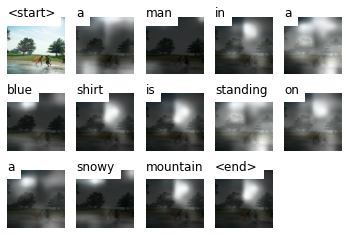

In [64]:
checkpoint = torch.load('./BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar', map_location=str(device))
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

with open('./Images/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json', 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}

seq, alphas = caption_image_beam_search(encoder, decoder,'./Images/1056249424_ef2a2e041c.jpg', word_map, 5)
alphas = torch.FloatTensor(alphas)
visualize_att('./Images/1056249424_ef2a2e041c.jpg', seq, alphas, rev_word_map, True)

In [ ]:
os.listdir('./Images/')